In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
from nltk.corpus import stopwords

import transformers
from transformers import Trainer, DataCollatorWithPadding, TrainingArguments, \
                         AutoModelForSequenceClassification, AutoTokenizer
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from datasets import Dataset, DatasetDict
import evaluate

import warnings

2025-03-30 19:35:13.258255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-30 19:35:13.258372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-30 19:35:13.383035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print('Transformers version is: ', transformers.__version__)
print('PyTorch version is: ', torch.__version__)

Transformers version is:  4.42.3
PyTorch version is:  2.1.2


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

warnings.filterwarnings('ignore')

## 1. Loading the data

In [6]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [7]:
print(f'Train df shape is: {train_df.shape}.')
print(f'Train df memory usage: {(train_df.memory_usage().sum() / 1024**2): .2f} MB.')
print('-----------------------------------')
print(f'Test df shape is: {test_df.shape}.')
print(f'Test df memory usage: {(test_df.memory_usage().sum() / 1024**2): .2f} MB.')

Train df shape is: (7613, 5).
Train df memory usage:  0.29 MB.
-----------------------------------
Test df shape is: (3263, 4).
Test df memory usage:  0.10 MB.


In [8]:
train_df.drop_duplicates(subset=['text'], inplace=True)

In [9]:
df = pd.concat([train_df, test_df], axis=0)

In [10]:
df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0


In [11]:
df.isna().sum()

id             0
keyword       82
location    3587
text           0
target      3263
dtype: int64

In [12]:
df.duplicated().sum()

0

<Axes: xlabel='target', ylabel='count'>

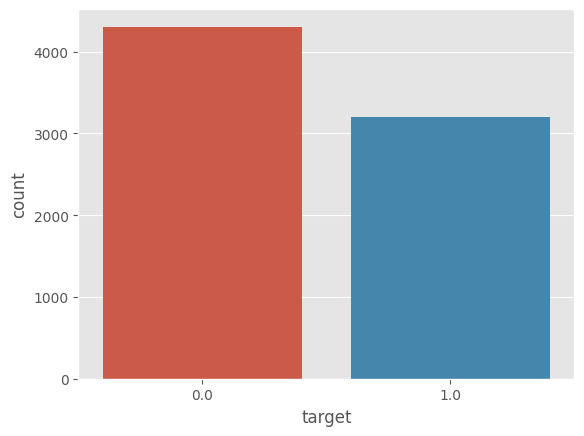

In [13]:
sns.countplot(x=df['target'])

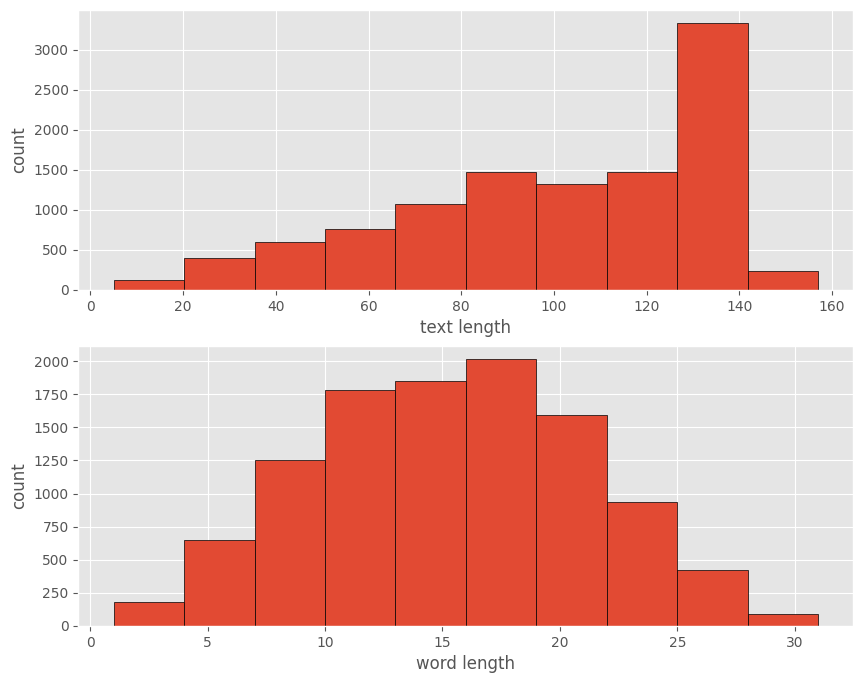

In [14]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
df['text'].str.len().plot(kind='hist', edgecolor='black')
plt.xlabel('text length')
plt.ylabel('count')

plt.subplot(2, 1, 2)
df['text'].str.split().map(lambda x: len(x)).hist(edgecolor='black')
plt.xlabel('word length')
plt.ylabel('count')

plt.show()

## 2. Data preprocessing

In [15]:
def text_preprocessing(txt):
    txt = txt.lower() 
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    txt = url_pattern.sub(r'', txt)
    html_tags_pattern = r'<.*?>'
    txt = re.sub(html_tags_pattern, '', txt)
    punctuation_pattern = r'[^\w\s]'
    txt = re.sub(punctuation_pattern, '', txt)
    return txt

In [16]:
df['cleaned_text'] = df['text'].apply(text_preprocessing)
df = df.drop(['id', 'keyword', 'location'], axis=1)

In [17]:
df = df.rename(columns={'target' : 'labels'})

In [18]:
df['text'] = df['cleaned_text']
df = df.drop('cleaned_text', axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10766 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    10766 non-null  object 
 1   labels  7503 non-null   float64
dtypes: float64(1), object(1)
memory usage: 252.3+ KB


In [20]:
df.tail(5)

,text,labels
3258,earthquake safety los angeles ûò safety fasten...,NaN
3259,storm in ri worse than last hurricane my citya...,NaN
3260,green line derailment in chicago,NaN
3261,meg issues hazardous weather outlook hwo,NaN
3262,cityofcalgary has activated its municipal emer...,NaN


In [21]:
def extract_and_count_words(words):
    words = words.values.tolist()

    words = [word for i in words for word in i]

    word_dict = {}

    for word in words:
        if word not in word_dict.keys():
            word_dict[word] = 1
        else:
            word_dict[word] += 1
            
    return word_dict

In [22]:
words_disaster = df.query('labels == 1').text.str.split()

words_no_disaster = df.query('labels == 0').text.str.split()

words_disaster_dict = extract_and_count_words(words_disaster)

words_no_disaster_dict = extract_and_count_words(words_no_disaster)

words_disaster_list = sorted(words_disaster_dict.items(), key=lambda item: item[1], reverse=True)

words_no_disaster_list = sorted(words_no_disaster_dict.items(), key=lambda item: item[1], reverse=True)

In [23]:
nltk.download('stopwords')

stopw = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
x_dis = []
y_dis = []
for word, count in words_disaster_list[:100]:
    if word not in stopw:
        x_dis.append(word)
        y_dis.append(count)
        
x_no_dis = []
y_no_dis = []
for word, count in words_no_disaster_list[:100]:
    if word not in stopw:
        x_no_dis.append(word)
        y_no_dis.append(count)

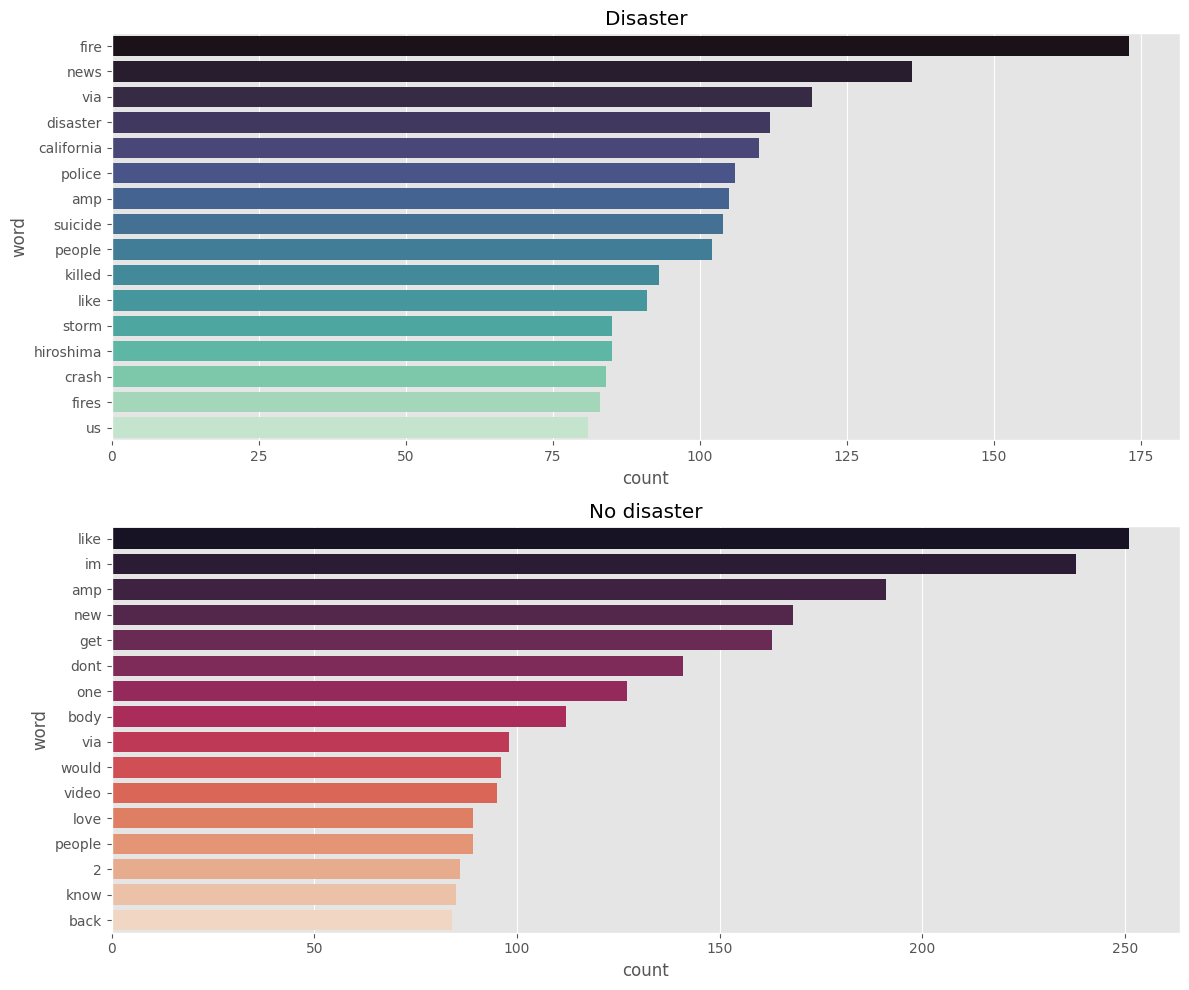

In [25]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.barplot(x=y_dis[:16], y=x_dis[:16], palette='mako')
plt.xlabel('count')
plt.ylabel('word')
plt.title('Disaster')

plt.subplot(2, 1, 2)
sns.barplot(x=y_no_dis[:16], y=x_no_dis[:16], palette='rocket')
plt.xlabel('count')
plt.ylabel('word')
plt.title('No disaster')

plt.tight_layout()
plt.show()

In [26]:
def get_top_10_ngram(words, n):
    cvec = CountVectorizer(ngram_range=(n, n)).fit(words)
    bag_of_words = cvec.transform(words)
    bow_sum = bag_of_words.sum(axis=0)
    words_freq = [(word, bow_sum[0, idx])
                  for word, idx in cvec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]
    

In [27]:
distaster_bigram = get_top_10_ngram(df.query('labels == 1').text, 2)
no_disaster_bigram = get_top_10_ngram(df.query('labels == 0').text, 2)

x_dis, y_dis = map(list, zip(*distaster_bigram))
x_no_dis, y_no_dis = map(list, zip(*no_disaster_bigram))

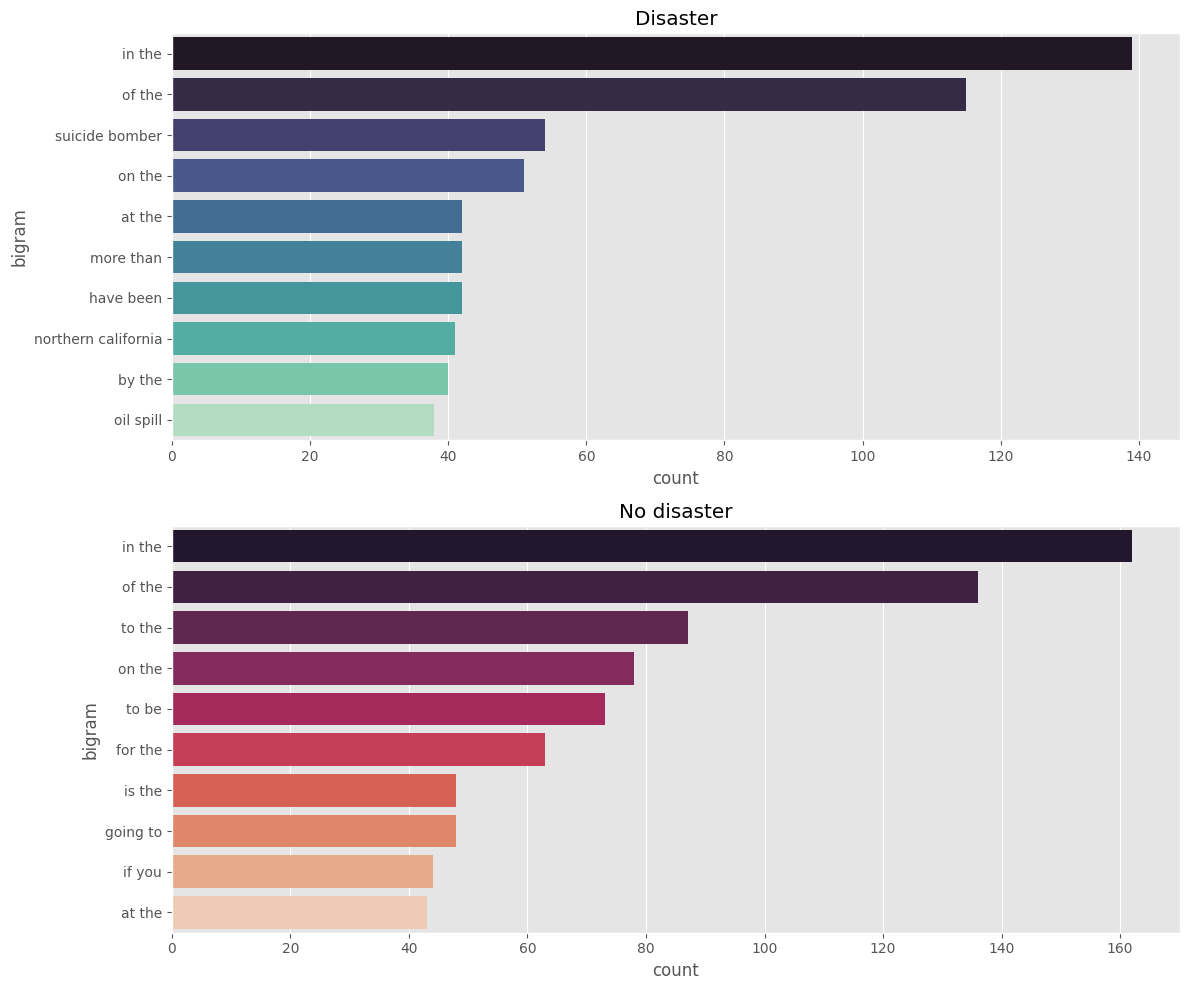

In [28]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.barplot(x=y_dis, y=x_dis, palette='mako')
plt.xlabel('count')
plt.ylabel('bigram')
plt.title('Disaster')

plt.subplot(2, 1, 2)
sns.barplot(x=y_no_dis, y=x_no_dis, palette='rocket')
plt.xlabel('count')
plt.ylabel('bigram')
plt.title('No disaster')

plt.tight_layout()
plt.show()

In [29]:
distaster_trigram = get_top_10_ngram(df.query('labels == 1').text, 3)
no_disaster_trigram = get_top_10_ngram(df.query('labels == 0').text, 3)

x_dis, y_dis = map(list, zip(*distaster_trigram))
x_no_dis, y_no_dis = map(list, zip(*no_disaster_trigram))

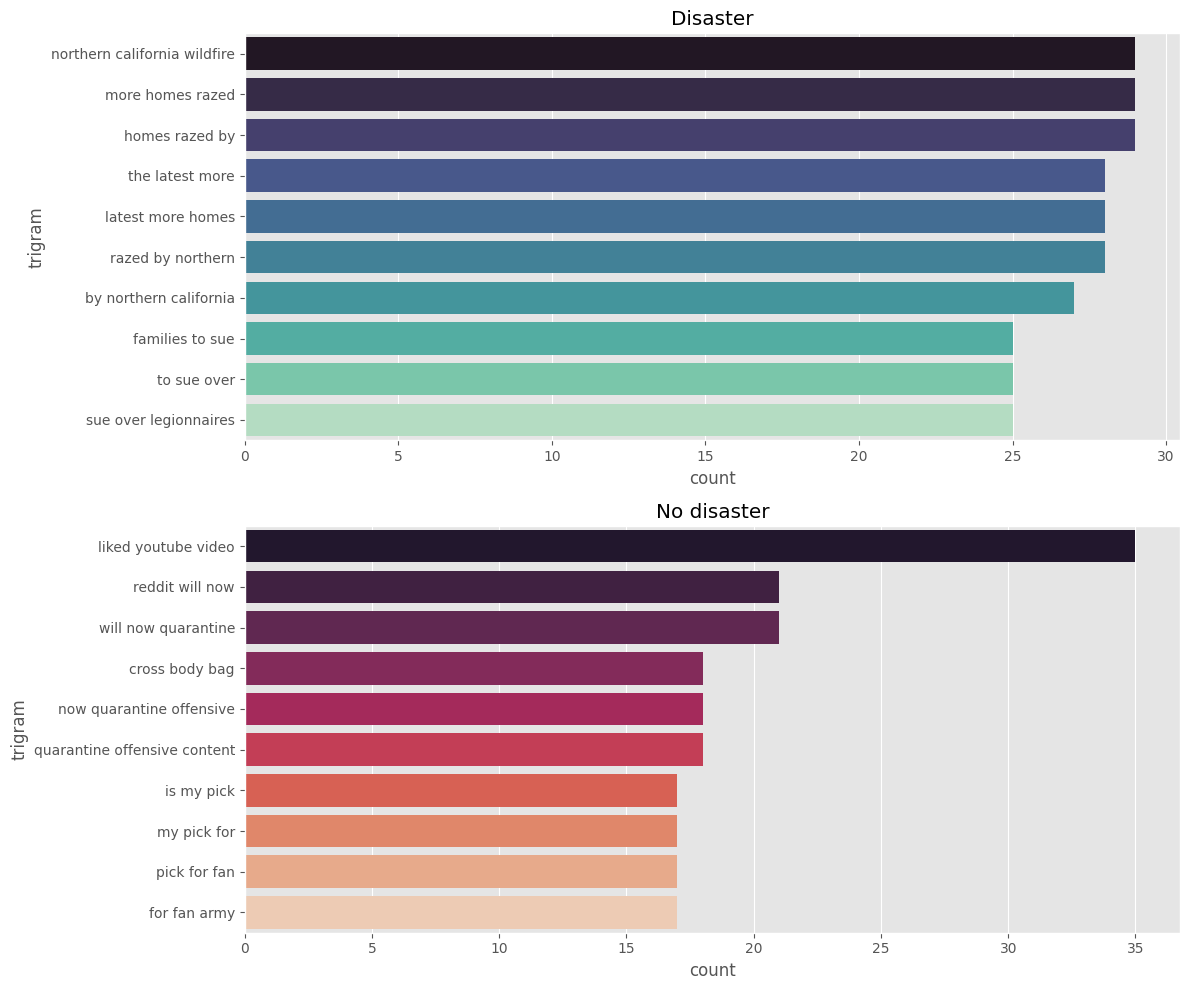

In [30]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.barplot(x=y_dis, y=x_dis, palette='mako')
plt.xlabel('count')
plt.ylabel('trigram')
plt.title('Disaster')

plt.subplot(2, 1, 2)
sns.barplot(x=y_no_dis, y=x_no_dis, palette='rocket')
plt.xlabel('count')
plt.ylabel('trigram')
plt.title('No disaster')

plt.tight_layout()
plt.show()

In [31]:
stopwords = set(STOPWORDS)

In [32]:
def show_wordcloud(data):
    wordcloud = WordCloud(background_color='black',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=30,
                          scale=3,
                          random_state=42)
    wordcloud = wordcloud.generate(str(data))
    
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud)
    plt.axis(False)

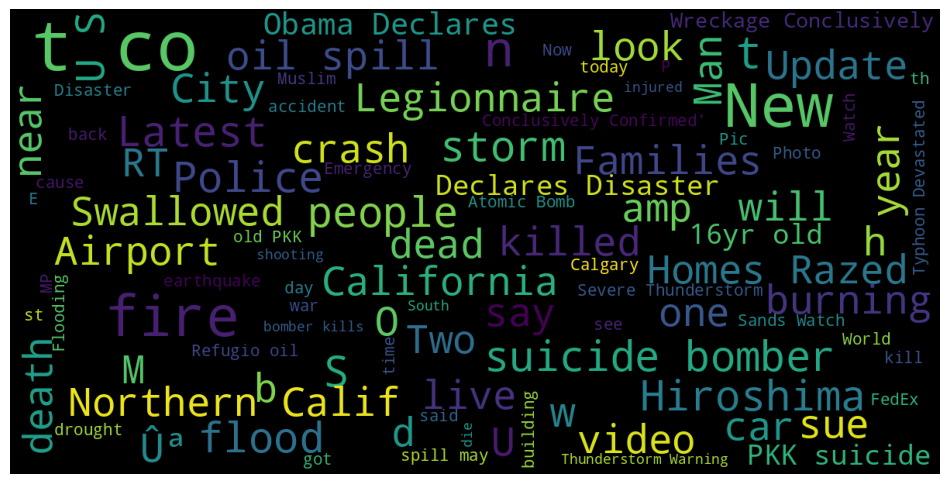

In [33]:
show_wordcloud(train_df.query('target == 1').text)

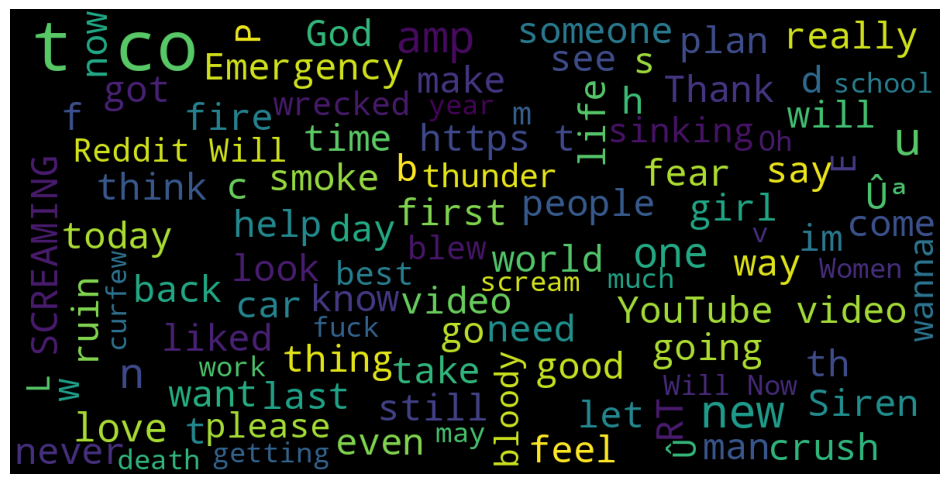

In [34]:
show_wordcloud(train_df.query('target == 0').text)

## 4. Dataset preparation

In [35]:
train_df = df[~df['labels'].isna()]
test_df = df[df['labels'].isna()]

In [36]:
train_df['labels'] = train_df['labels'].astype('int64')

In [37]:
train_df.head()

,text,labels
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1


In [38]:
train_df.tail(2)

,text,labels
7608,two giant cranes holding a bridge collapse int...,1
7612,the latest more homes razed by northern califo...,1


In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7503 non-null   object
 1   labels  7503 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 175.9+ KB


In [40]:
train_df, eval_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

In [41]:
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

In [42]:
raw_dataset = DatasetDict({
    'train' : Dataset.from_pandas(train_df),
    'eval' : Dataset.from_pandas(eval_df)
})

In [43]:
print(raw_dataset)
print(raw_dataset['train'].features)
print(raw_dataset['train'][0])

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6002
    })
    eval: Dataset({
        features: ['text', 'labels'],
        num_rows: 1501
    })
})
{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None)}
{'text': 'universityoflaw for the people who died in human experiments by unit 731 of japanese military  ', 'labels': 1}


## 5. Model

In [44]:
# checkpoint = "bert-base-uncased" 

checkpoint = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.1 Tokenizing

In [45]:
tokenized_ds = raw_dataset.map(lambda ds: tokenizer(ds['text'], truncation=True), batched=True)

Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

In [46]:
tokenized_ds = tokenized_ds.remove_columns(['text'])

In [47]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### 5.1 Training the model

In [48]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


training_args = TrainingArguments('distilbert-disaster-tweets', num_train_epochs=2, eval_strategy="epoch", 
                                  learning_rate=2e-5, weight_decay=0.01, save_strategy="no", report_to="none")

In [49]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [50]:
trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_ds['train'],
                  eval_dataset=tokenized_ds['eval'])

In [51]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.462000,0.387105,0.842771,0.790409
2,0.341100,0.447683,0.844770,0.808546


TrainOutput(global_step=1502, training_loss=0.39098093990539107, metrics={'train_runtime': 52.6518, 'train_samples_per_second': 227.989, 'train_steps_per_second': 28.527, 'total_flos': 95042253831024.0, 'train_loss': 0.39098093990539107, 'epoch': 2.0})

In [52]:
eval_preds = trainer.predict(tokenized_ds['eval'])
eval_preds = eval_preds.predictions.argmax(axis=1)

In [53]:
y_true = raw_dataset['eval']['labels']
y_pred = eval_preds

In [54]:
f1 = f1_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

In [55]:
metrics = {
    'F1' : f1,
    'Acc' : acc,
    'Precision' : prec,
    'Recall' : recall
}

In [56]:
for metric, score in metrics.items():
    print(f'{metric} : {score}')

F1 : 0.8085456039441249
Acc : 0.8447701532311792
Precision : 0.8338983050847457
Recall : 0.784688995215311


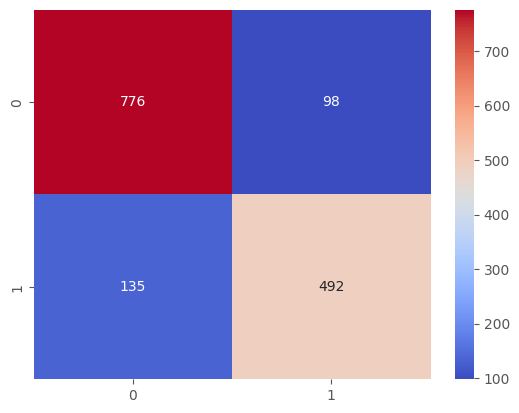

In [57]:
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, cmap='coolwarm', annot=True, fmt='d')
plt.show()

## 6. Making predictions

In [58]:
test_df = test_df.drop('labels', axis=1)

In [59]:
test_ds = Dataset.from_pandas(test_df)

In [60]:
test_tokenized_ds = test_ds.map(lambda ds: tokenizer(ds['text'], truncation=True), batched=True)

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [61]:
test_tokenized_ds[0]

{'text': 'just happened a terrible car crash',
 '__index_level_0__': 0,
 'input_ids': [101, 2074, 3047, 1037, 6659, 2482, 5823, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [62]:
test_tokenized_ds = test_tokenized_ds.remove_columns(['text', '__index_level_0__'])

In [63]:
preds = trainer.predict(test_tokenized_ds)

In [64]:
preds = preds.predictions.argmax(axis=1)

In [65]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
ids = df_test.id

In [66]:
submission = pd.DataFrame({'id' : ids, 'target' : preds})

In [67]:
submission.to_csv('submission.csv', index=False)